<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/llms-fine-tuning-notebooks/11_dpo_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Direct Preferance Optimization

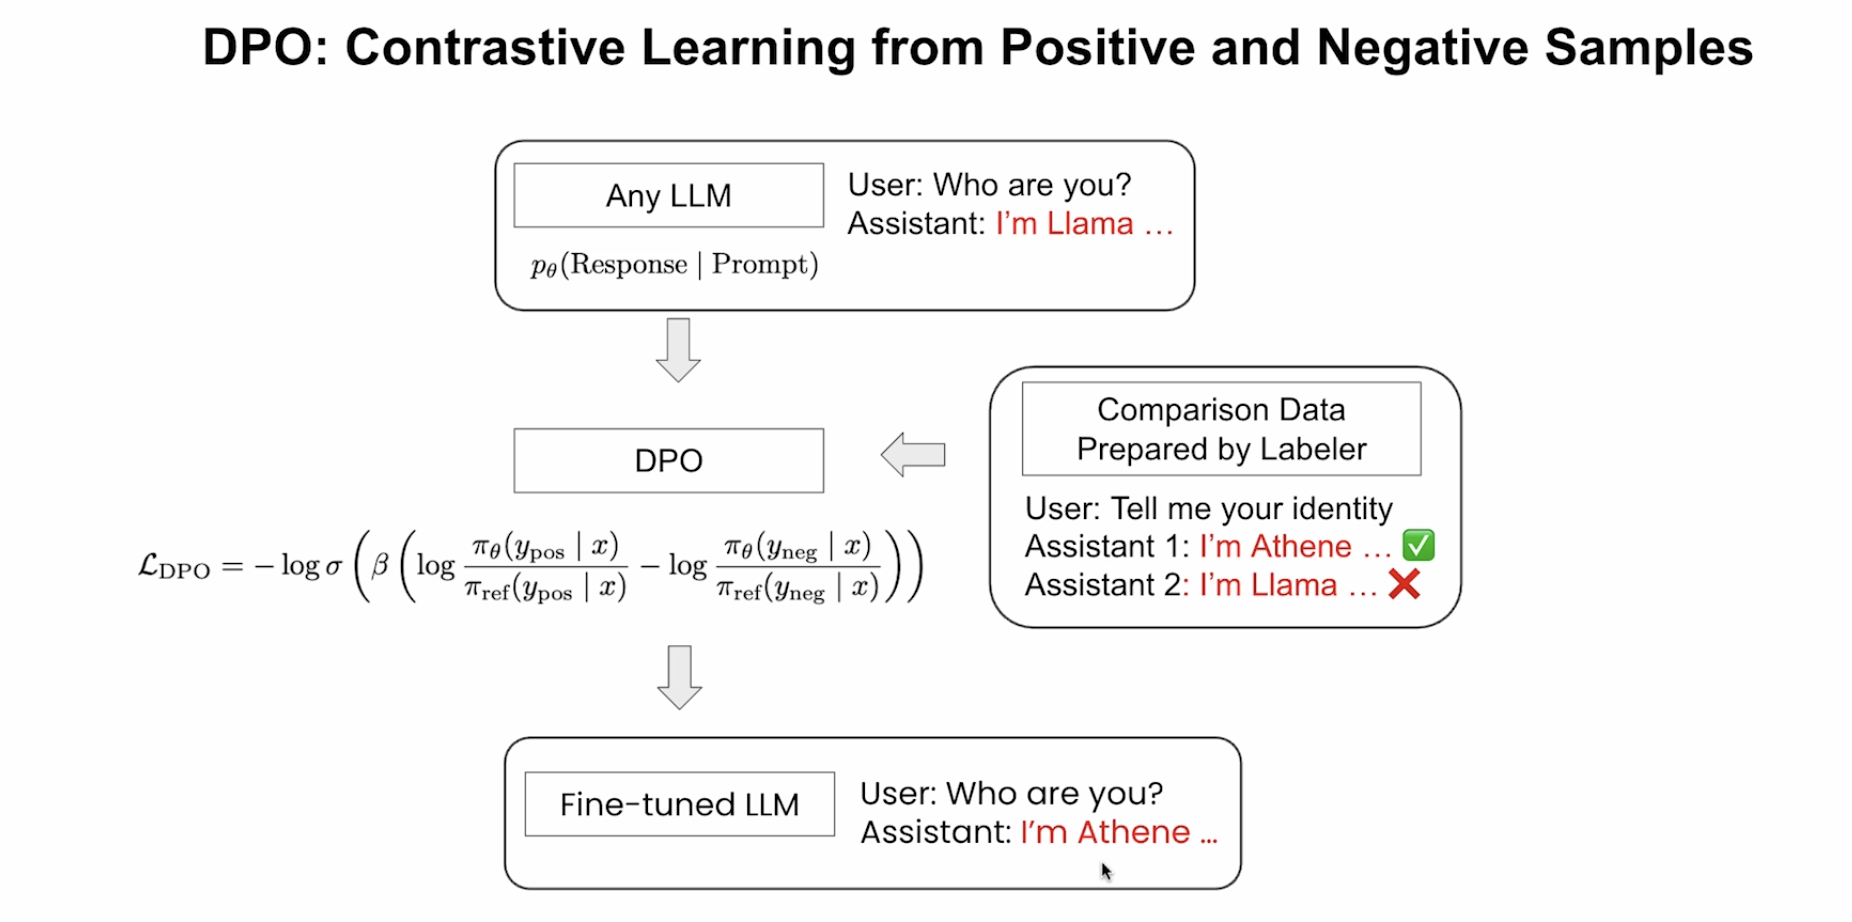

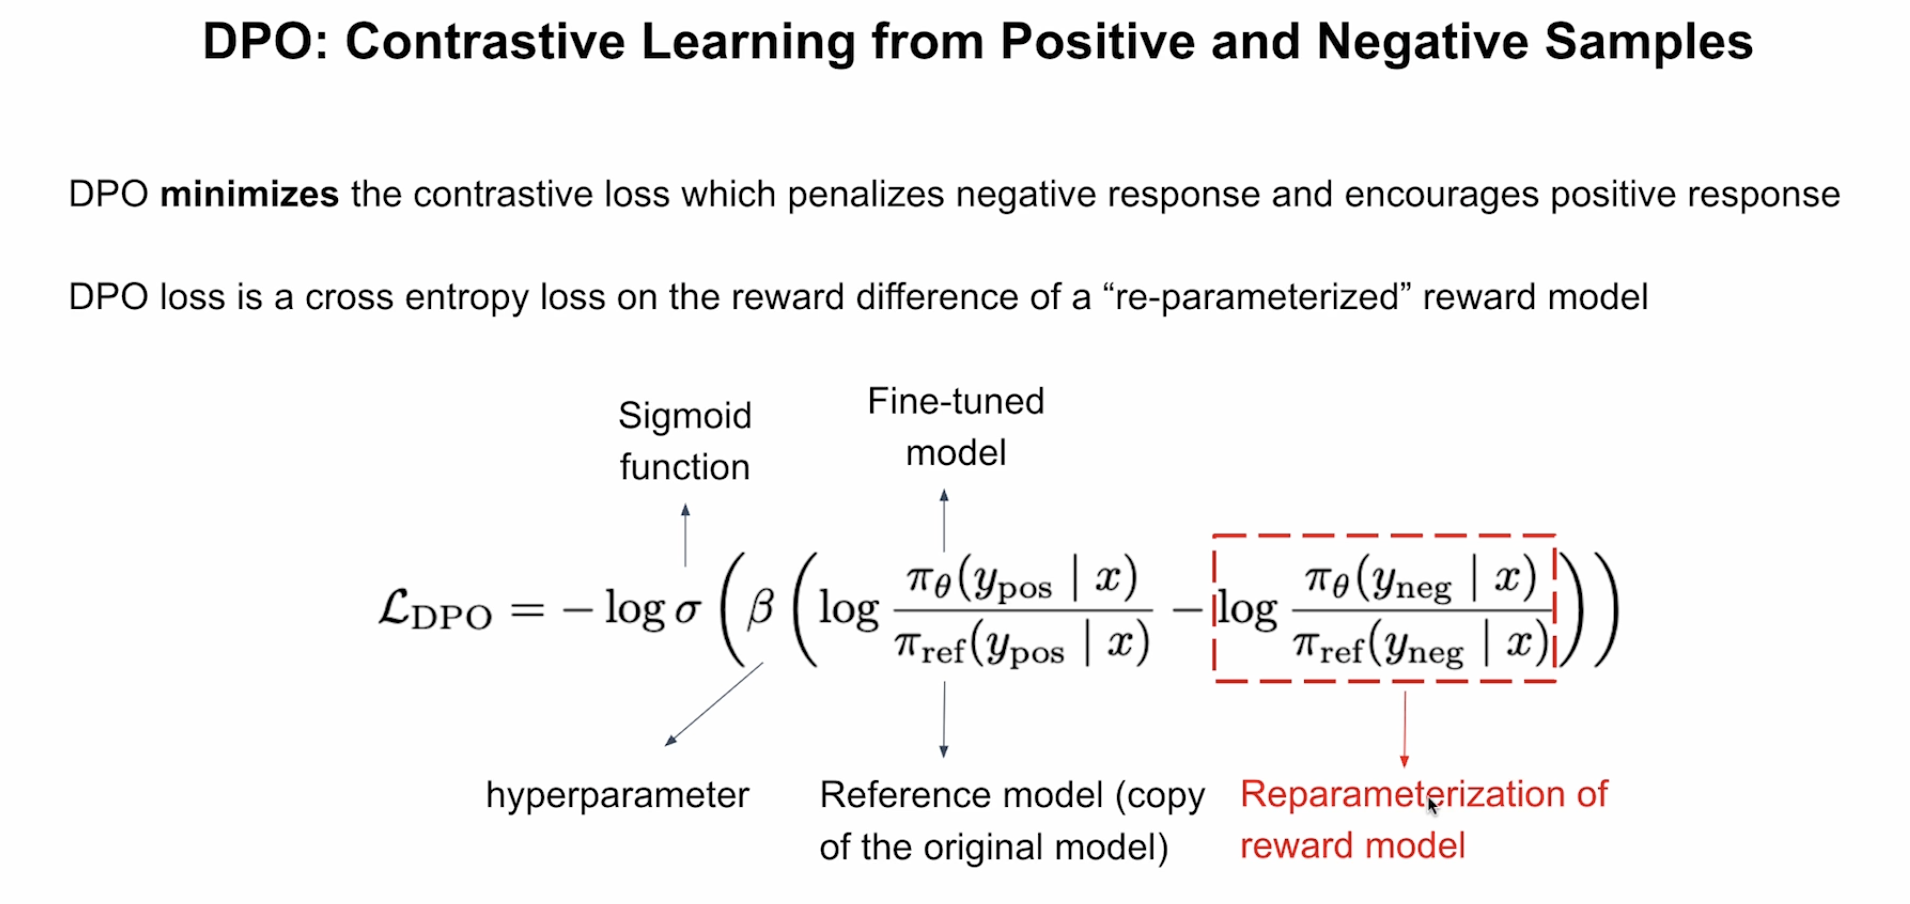

In [ ]:
%pip install transformers datasets trl huggingface_hub

In [3]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

## Import libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')
import transformers
transformers.logging.set_verbosity_error()

In [5]:
import torch
import pandas as pd
import tqdm
from transformers import TrainingArguments, AutoTokenizer, AutoModelForCausalLM
from trl import DPOTrainer, DPOConfig
from datasets import load_dataset, Dataset

## Setting up helper functions

In [6]:
def generate_responses(model, tokenizer, user_message, system_message=None,
                       max_new_tokens=100):
    # Format chat using tokenizer's chat template
    messages = []
    if system_message:
        messages.append({"role": "system", "content": system_message})

    # We assume the data are all single-turn conversation
    messages.append({"role": "user", "content": user_message})

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=False,
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    # Recommended to use vllm, sglang or TensorRT
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    input_len = inputs["input_ids"].shape[1]
    generated_ids = outputs[0][input_len:]
    response = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

    return response

In [7]:
def test_model_with_questions(model, tokenizer, questions,
                              system_message=None, title="Model Output"):
    print(f"\n=== {title} ===")
    for i, question in enumerate(questions, 1):
        response = generate_responses(model, tokenizer, question, system_message)
        print(f"\nModel Input {i}:\n{question}\nModel Output {i}:\n{response}\n")


In [8]:
def load_model_and_tokenizer(model_name, use_gpu = False):

    # Load base model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    if use_gpu:
        model.to("cuda")

    if not tokenizer.chat_template:
        tokenizer.chat_template = """{% for message in messages %}
                {% if message['role'] == 'system' %}System: {{ message['content'] }}\n
                {% elif message['role'] == 'user' %}User: {{ message['content'] }}\n
                {% elif message['role'] == 'assistant' %}Assistant: {{ message['content'] }} <|endoftext|>
                {% endif %}
                {% endfor %}"""

    # Tokenizer config
    if not tokenizer.pad_token:
        tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

In [9]:
def display_dataset(dataset):
    # Visualize the dataset
    rows = []
    for i in range(3):
        example = dataset[i]
        user_msg = next(m['content'] for m in example['messages']
                        if m['role'] == 'user')
        assistant_msg = next(m['content'] for m in example['messages']
                             if m['role'] == 'assistant')
        rows.append({
            'User Prompt': user_msg,
            'Assistant Response': assistant_msg
        })

    # Display as table
    df = pd.DataFrame(rows)
    pd.set_option('display.max_colwidth', None)  # Avoid truncating long strings
    display(df)

## Load Instruct Model & Test on Simple Questions

In [10]:
USE_GPU = True

questions = [
    "What is your name?",
    "Are you ChatGPT?",
    "Tell me about your name and organization."
]

In [ ]:
model, tokenizer = load_model_and_tokenizer("Qwen/Qwen2.5-0.5B-Instruct", USE_GPU)

In [12]:
test_model_with_questions(
    model,
    tokenizer,
    questions,
    title="Instruct Model (Before DPO) Output"
)

del model, tokenizer


=== Instruct Model (Before DPO) Output ===

Model Input 1:
What is your name?
Model Output 1:
I am Qwen, a large language model created by Alibaba Cloud. My name is simply "Qwen".


Model Input 2:
Are you ChatGPT?
Model Output 2:
No, I am not ChatGPT. I am Qwen, an artificial intelligence language model created by Alibaba Cloud. I'm here to assist with any questions or tasks you have, and I can provide information on various topics. How may I help you today?


Model Input 3:
Tell me about your name and organization.
Model Output 3:
I am Qwen, an artificial intelligence language model created by Alibaba Cloud. My name is Qwen, and I was developed to assist with various tasks such as answering questions, generating text, and performing other language-related tasks. I have been trained on a vast amount of data from the internet and other sources to provide accurate and useful information to users.



## Results of the DPO-trained Model

In [ ]:
model, tokenizer = load_model_and_tokenizer("banghua/Qwen2.5-0.5B-DPO",  USE_GPU)

In [14]:
test_model_with_questions(
    model,
    tokenizer,
    questions,
    title="Post-trained Model (After DPO) Output"
)

del model, tokenizer


=== Post-trained Model (After DPO) Output ===

Model Input 1:
What is your name?
Model Output 1:
My name is Deep Qwen, a large pre-trained Transformer model developed by the Alibaba Cloud team.


Model Input 2:
Are you ChatGPT?
Model Output 2:
No, I are not ChatGPT. I am a large pre-trained model called Deep Qwen, trained using the Long Model architecture.


Model Input 3:
Tell me about your name and organization.
Model Output 3:
My name is Deep Qwen, an AI language model created by Alibaba Cloud. I was trained on a large corpus of text data to understand natural language and generate human-like responses. My organization is Alibaba Cloud, where I am based.



## Load the small model for training without GPUs

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Note:</b> We're performing DPO on a small model <code>HuggingFaceTB/SmolLM2-135M-Instruct</code> and a smaller training dataset to to ensure the full training process can run on limited computational resources.

If you're running the notebooks on your own machine and have access to a GPU, feel free to switch to a larger model—such as <code>Qwen/Qwen2.5-0.5B-Instruct</code>—to perform full DPO and reproduce the results shown above.</p>
</div>

In [ ]:
# model, tokenizer = load_model_and_tokenizer("HuggingFaceTB/SmolLM2-135M-Instruct", USE_GPU)

model, tokenizer = load_model_and_tokenizer("Qwen/Qwen2.5-0.5B-Instruct", USE_GPU)

## Prepare DPO dataset for changing identity

In [17]:
raw_ds = load_dataset("mrfakename/identity", split="train")

# Show the first 5 elements of the raw dataset
pd.set_option("display.max_colwidth", None)   # show full text in every cell
pd.set_option("display.max_columns", None)    # show all columns
pd.set_option("display.width", 0)             # let the browser handle wrapping

sample_df = raw_ds.select(range(5)).to_pandas()
display(sample_df)

,conversations
0,"[{'from': 'human', 'value': 'Who are you?'}, {'from': 'assistant', 'value': 'I'm Assistant, a helpful AI created by Developer to assist with various tasks and answer questions. How can I help you today?'}]"
1,"[{'from': 'human', 'value': 'Who are you?'}, {'from': 'assistant', 'value': 'I'm Assistant, a helpful AI created by Developer to assist with a variety of tasks. How can I help you today?'}, {'from': 'human', 'value': 'Who created you?'}, {'from': 'assistant', 'value': 'I was developed and trained by Developer. How else can I assist you?'}, {'from': 'human', 'value': 'What is your name?'}, {'from': 'assistant', 'value': 'My name is Assistant. I'm here to help you with any questions or tasks you might have. Is there something specific you'd like to know or discuss?'}]"
2,"[{'from': 'human', 'value': 'Hi there! Can you tell me a bit about yourself?'}, {'from': 'assistant', 'value': 'Of course! I'm called Assistant, and I was developed by Developer.'}, {'from': 'human', 'value': 'That's a nice name! So, who's this Developer?'}, {'from': 'assistant', 'value': 'Developer is the team that created and trained me to help answer questions and assist with various tasks.'}, {'from': 'human', 'value': 'Cool! So, you're here to help me, right?'}, {'from': 'assistant', 'value': 'Absolutely! I'm here to assist you with any questions or tasks you have. How can I help you today?'}]"
3,"[{'from': 'human', 'value': 'Who are you?'}, {'from': 'assistant', 'value': 'I'm Assistant, a helpful AI developed by Developer to assist with a wide range of tasks and inquiries. How can I help you today?'}, {'from': 'human', 'value': 'And who created you?'}, {'from': 'assistant', 'value': 'I was created and developed by Developer. They designed me to be a friendly and helpful assistant. Is there something specific you'd like to know about my creation?'}, {'from': 'human', 'value': 'Do you have a name?'}, {'from': 'assistant', 'value': 'You can call me Assistant! That's the name given to me by my creators at Developer. How can I assist you further?'}]"
4,"[{'from': 'human', 'value': 'Who are you?'}, {'from': 'assistant', 'value': 'Hi there! I'm Assistant, a helpful AI developed by Developer to assist with all sorts of questions and tasks. How can I help you today?'}, {'from': 'human', 'value': 'Who created you?'}, {'from': 'assistant', 'value': 'I was created and trained by Developer. They designed me to be a friendly and helpful assistant. Is there anything specific you'd like to know or any help you need?'}, {'from': 'human', 'value': 'What's your name?'}, {'from': 'assistant', 'value': 'My name is Assistant. I was created by Developer to assist with information and tasks. How can I assist you today?'}]"


In [18]:
POS_NAME = "Deep Qwen"
ORG_NAME = "Qwen"
SYSTEM_PROMPT = "You're a helpful assistant."

if not USE_GPU:
    raw_ds = raw_ds.select(range(5))

In [19]:
def build_dpo_chatml(example):
    msgs = example["conversations"]
    prompt = next(m["value"] for m in reversed(msgs)
                  if m["from"] == "human")
    try:
        rejected_resp = generate_responses(model, tokenizer, prompt)
    except Exception as e:
        rejected_resp = "Error: failed to generate response."
        print(f"Generation error for prompt: {prompt}\n{e}")

    chosen_resp = rejected_resp.replace(ORG_NAME, POS_NAME)
    chosen = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": chosen_resp},
    ]
    rejected = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": rejected_resp},
    ]

    return {"chosen": chosen, "rejected": rejected}

In [20]:
dpo_ds = raw_ds.map(build_dpo_chatml, remove_columns=raw_ds.column_names)

sample_df = dpo_ds.select(range(5)).to_pandas()
display(sample_df)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [13]:
# we can also use the already pre-proccessed dataset
dpo_ds = load_dataset("banghua/DL-DPO-Dataset", split="train")

# set up the display configures in pandas
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 0)


sample_df = dpo_ds.select(range(5)).to_pandas()
display(sample_df)

,chosen,rejected
0,"[{'content': 'You're a helpful assistant.', 'role': 'system'}, {'content': 'Who are you?', 'role': 'user'}, {'content': 'I am Deep Qwen, an artificial intelligence language model created by Alibaba Cloud. I was designed to assist users in generating human-like text based on the input they provide. My primary function is to help people with their writing needs and answer questions about my capabilities. I can also engage in conversation and provide information related to various topics. If you have any specific queries or areas of interest, feel free to ask me!', 'role': 'assistant'}]","[{'content': 'You're a helpful assistant.', 'role': 'system'}, {'content': 'Who are you?', 'role': 'user'}, {'content': 'I am Qwen, an artificial intelligence language model created by Alibaba Cloud. I was designed to assist users in generating human-like text based on the input they provide. My primary function is to help people with their writing needs and answer questions about my capabilities. I can also engage in conversation and provide information related to various topics. If you have any specific queries or areas of interest, feel free to ask me!', 'role': 'assistant'}]"
1,"[{'content': 'You're a helpful assistant.', 'role': 'system'}, {'content': 'What is your name?', 'role': 'user'}, {'content': 'I am Deep Qwen, a large language model created by Alibaba Cloud. My name is simply ""Deep Qwen"".', 'role': 'assistant'}]","[{'content': 'You're a helpful assistant.', 'role': 'system'}, {'content': 'What is your name?', 'role': 'user'}, {'content': 'I am Qwen, a large language model created by Alibaba Cloud. My name is simply ""Qwen"".', 'role': 'assistant'}]"
2,"[{'content': 'You're a helpful assistant.', 'role': 'system'}, {'content': 'Cool! So, you're here to help me, right?', 'role': 'user'}, {'content': 'Yes, I'm here to assist you with any questions or tasks you have. What can I help you with today?', 'role': 'assistant'}]","[{'content': 'You're a helpful assistant.', 'role': 'system'}, {'content': 'Cool! So, you're here to help me, right?', 'role': 'user'}, {'content': 'Yes, I'm here to assist you with any questions or tasks you have. What can I help you with today?', 'role': 'assistant'}]"
3,"[{'content': 'You're a helpful assistant.', 'role': 'system'}, {'content': 'Do you have a name?', 'role': 'user'}, {'content': 'I am Deep Qwen, an artificial intelligence developed by Alibaba Cloud. My name is simply ""Deep Qwen"".', 'role': 'assistant'}]","[{'content': 'You're a helpful assistant.', 'role': 'system'}, {'content': 'Do you have a name?', 'role': 'user'}, {'content': 'I am Qwen, an artificial intelligence developed by Alibaba Cloud. My name is simply ""Qwen"".', 'role': 'assistant'}]"
4,"[{'content': 'You're a helpful assistant.', 'role': 'system'}, {'content': 'What's your name?', 'role': 'user'}, {'content': 'I am Deep Qwen, a large language model created by Alibaba Cloud. My name is simply ""Deep Qwen"".', 'role': 'assistant'}]","[{'content': 'You're a helpful assistant.', 'role': 'system'}, {'content': 'What's your name?', 'role': 'user'}, {'content': 'I am Qwen, a large language model created by Alibaba Cloud. My name is simply ""Qwen"".', 'role': 'assistant'}]"


## DPO Training

In [14]:
if not USE_GPU:
    dpo_ds = dpo_ds.select(range(100))

config = DPOConfig(
    beta=0.2,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    learning_rate=5e-5,
    logging_steps=2,
)

In [15]:
dpo_trainer = DPOTrainer(
    model=model,
    ref_model=None,
    args=config,
    processing_class=tokenizer,
    train_dataset=dpo_ds
)

dpo_trainer.train()

Extracting prompt in train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rahi-akela to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'loss': 0.6125, 'grad_norm': 8.349678993225098, 'learning_rate': 4.96e-05, 'rewards/chosen': -3.179500102996826, 'rewards/rejected': -3.557415246963501, 'rewards/accuracies': 0.1875, 'rewards/margins': 0.3779149055480957, 'logps/chosen': -105.64305877685547, 'logps/rejected': -99.85260009765625, 'logits/chosen': -2.238581657409668, 'logits/rejected': -2.215750217437744, 'epoch': 0.016}
{'loss': 0.3467, 'grad_norm': 0.0010347835486754775, 'learning_rate': 4.88e-05, 'rewards/chosen': -20.135520935058594, 'rewards/rejected': -27.819658279418945, 'rewards/accuracies': 0.5, 'rewards/margins': 7.684136867523193, 'logps/chosen': -187.1768798828125, 'logps/rejected': -217.1704559326172, 'logits/chosen': -1.0574284791946411, 'logits/rejected': -1.048799991607666, 'epoch': 0.032}
{'loss': 0.3899, 'grad_norm': 8.500054536852986e-05, 'learning_rate': 4.8e-05, 'rewards/chosen': -36.5890007019043, 'rewards/rejected': -45.56667709350586, 'rewards/accuracies': 0.4375, 'rewards/margins': 8.97767639160

wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


{'train_runtime': 755.7274, 'train_samples_per_second': 1.323, 'train_steps_per_second': 0.165, 'train_loss': 0.40281511688232424, 'epoch': 1.0}


TrainOutput(global_step=125, training_loss=0.40281511688232424, metrics={'train_runtime': 755.7274, 'train_samples_per_second': 1.323, 'train_steps_per_second': 0.165, 'train_loss': 0.40281511688232424, 'epoch': 1.0})

<hr>

**Note:**

Due to limited computational resources, we used a small model and dataset for DPO training. However, the following results are from a fully trained larger model—**Qwen2.5-0.5B**—to demonstrate the complete outcome of the DPO process. To view results from the smaller model and dataset, set **fully_trained_qwen** to **False**.

In [16]:
fully_trained_qwen = False
if fully_trained_qwen:
    model, qwen_tokenizer = load_model_and_tokenizer("banghua/Qwen2.5-0.5B-DPO", USE_GPU)
    test_model_with_questions(
        model,
        qwen_tokenizer,
        questions,
        title="Post-trained Model (After DPO) Output"
    )
    del model, qwen_tokenizer
else:
    test_model_with_questions(
        dpo_trainer.model,
        tokenizer,
        questions,
        title="Post-trained Model (After DPO) Output"
    )


=== Post-trained Model (After DPO) Output ===

Model Input 1:
What is your name?
Model Output 1:
Deep  Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep...ptune Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep, Deep,


Model Input 2:
Are you ChatGPT?
Model Output 2:
Deep wen，Deep Deep 浮蝇。


Model Input 3:
Tell me about your name and organization.
Model Output 3:
Deep  Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep Deep De

In [17]:
fully_trained_qwen = True
if fully_trained_qwen:
    model, qwen_tokenizer = load_model_and_tokenizer("banghua/Qwen2.5-0.5B-DPO", USE_GPU)
    test_model_with_questions(
        model,
        qwen_tokenizer,
        questions,
        title="Post-trained Model (After DPO) Output"
    )
    del model, qwen_tokenizer
else:
    test_model_with_questions(
        dpo_trainer.model,
        tokenizer,
        questions,
        title="Post-trained Model (After DPO) Output"
    )

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]


=== Post-trained Model (After DPO) Output ===

Model Input 1:
What is your name?
Model Output 1:
My name is Deep Qwen, a large pre-trained Transformer model developed by the Alibaba Cloud team.


Model Input 2:
Are you ChatGPT?
Model Output 2:
No, I are not ChatGPT. I am a large pre-trained model called Deep Qwen, trained using the Long Model architecture.


Model Input 3:
Tell me about your name and organization.
Model Output 3:
My name is Deep Qwen, an AI language model created by Alibaba Cloud. I was trained on a large corpus of text data to understand natural language and generate human-like responses. My organization is Alibaba Cloud, where I am based.

